In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

In [2]:
def blob_mean_and_tangent(contour):

    moments = cv2.moments(contour)

    area = moments['m00']

    mean_x = moments['m10'] / area
    mean_y = moments['m01'] / area

    moments_matrix = np.array([
        [moments['mu20'], moments['mu11']],
        [moments['mu11'], moments['mu02']]
    ]) / area

    _, svd_u, _ = cv2.SVDecomp(moments_matrix)

    center = np.array([mean_x, mean_y])
    tangent = svd_u[:, 0].flatten().copy()

    return center, tangent 


def span_min_max_point(contour, center, tangent):
    points_projected = []
    for c in contour:
        points_projected.append(np.dot(c - center, tangent))
    
    lxmin = min(points_projected)
    lxmax = max(points_projected)
    
    min_p = center + tangent * lxmin
    max_p = center + tangent * lxmax
    
    return min_p, max_p


def plot_contour(df):
    rc = {"font.family" : "serif", "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
    plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
    plt.rc('text', usetex=True)
    
    # get left top and right bottom points
    xmin, ymin = df.min()
    xmax, ymax = df.max()
    
    # calc width and height
    width = xmax - xmin
    height = ymax - ymin
    
    # move origin of contour to (xmin, ymin)
    df_moved = df - df.min()
    
    # generate figure
    fig = plt.figure(figsize=(width / height * 2, 2.), dpi=300)
    
    # generate subplot
    ax = fig.add_subplot(1, 1, 1)
    
    # set xlim and ylim
    ax.set_xlim(xmin - 1, xmax + 1)
    ax.set_ylim(ymin - 1, ymax + 1)
    
    # plot contour
    ax.scatter(df.x, df.y, s=10, color='tab:blue')
    
#     # add bounding rectangle
#     ax.add_patch(
#         patches.Rectangle(
#             (xmin, ymin),
#             width,
#             height,
#             linewidth=0.5,
#             fill=False,
#             label='Bounding rectangle'
#         )
#     )
    
    # get center and variance direction of contours
    center, tangent = blob_mean_and_tangent(df.values)
    
    # add center circle
    ax.add_patch(
        patches.Circle(
            center,
            radius=1,
            fill=False,
            linewidth=1
        )
    )
    
    # plot axis
    ax.axhline(y=center[1], color='gray', linewidth=1.5)
    
    # get min, max points of span[u_1]
    min_p, max_p = span_min_max_point(df.values, center, tangent)
    
    # plot span
    ax.plot([min_p[0], max_p[0]], [min_p[1], max_p[1]], c='tab:orange', linewidth=2)
    
    # calculate angle between span and x-axis
    angle = np.arctan2(tangent[1], tangent[0])
    
    # plot angle between span and x-axis
    arc_width, arc_height = 40, 40
    ax.add_patch(
        patches.Arc(
            center,
            arc_width, 
            arc_height,
            0,
            theta1=0,
            theta2=np.degrees(angle),
            color='tab:red',
            linewidth=1.5
        )
    )
    
    # text
    text_x = center[0] + np.cos(angle / 2) * (arc_width + 2) / 2
    text_y = center[1] + np.sin(angle / 2) * (arc_height + 2) / 2
    ax.text(text_x, text_y + 1, r'$\theta$', fontsize=22)
    
    # plot minimum and maximum points of the span
    ax.scatter(min_p[0], min_p[1], s=32, color='tab:red', zorder=5)
    ax.scatter(max_p[0], max_p[1], s=32, color='tab:purple', zorder=5)
    
    # invert y-axis
    ax.invert_yaxis()
    
    # set xticklabels
    ticks = ax.get_xticks()
    ticklabels = [f'{int(x + xmin)}' for x in ticks]
    
    ax.set_xticklabels(ticklabels)
    
    # set tick fontsize
    ax.tick_params(axis='both', labelsize=22)
    
#     # legend
#     legend_elements = [lines.Line2D([0], [0], color='tab:orange', label='Span($u_1$)'),
#                        lines.Line2D([0], [0], marker='o', markersize=6, color='w', markerfacecolor='tab:blue', label='Contour points'),
#                        lines.Line2D([0], [0], marker='o', markersize=6, color='w', markerfacecolor='tab:red', label='Min projected points'),
#                        lines.Line2D([0], [0], marker='o', markersize=6, color='w', markerfacecolor='tab:purple', label='Max projected points')]
    
#     #fig.legend(handles=legend_elements, fontsize=12, loc='center right', bbox_to_anchor=(1.04, 0.5))
#     fig.legend(handles=legend_elements, fontsize=12, loc='lower left', bbox_to_anchor=(0.1, -0.8))
    
    ax.set_axis_off()
    
    plt.savefig('contours.png', bbox_inches='tight')

In [3]:
df = pd.read_csv('contour/7.csv', header=None)
df.columns = ['x', 'y']

<ipython-input-2-66c9313f0e00>:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels)


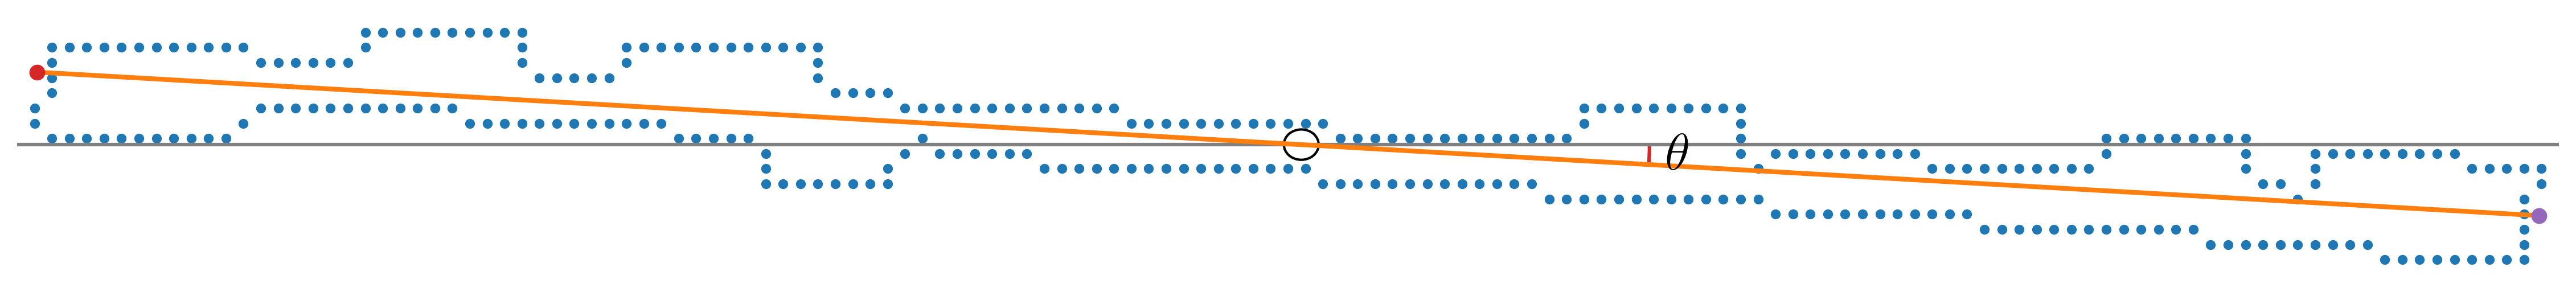

In [4]:
plot_contour(df)